In [1]:
from src import data_loader as dl
import pandas as pd
import numpy as np
import torch
import os

## Preprocessing Steps

In [24]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16
N_SYSTEMS = 10
RADIUS = 0.5

In [25]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 1 m : 44 sec



In [26]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location, df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv, 8, 16)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv, 0.05)


Dropping 27 systems producing over night


In [28]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                        df_location=df_location)
df_pv['datetime'] = datetime

In [29]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [46]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 8 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [47]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [48]:
N_DAYS = 4
N_SYSTEMS = 10
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL

LDN_COORDS = (51.5074, -0.1278)

In [49]:
ldn_systems = dl.find_nearby_systems(df_location, 
                                     lat=LDN_COORDS[0],
                                     lon=LDN_COORDS[1],
                                     radius=RADIUS)

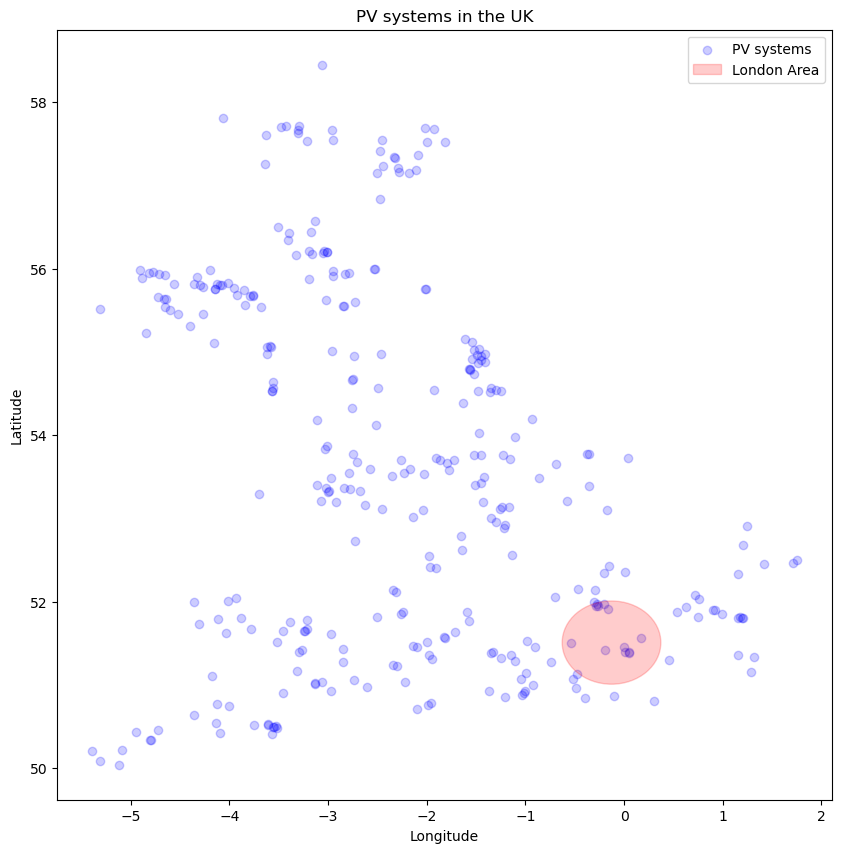

In [50]:
# scatter plot df_location
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_location['longitude_noisy'], df_location['latitude_noisy'], alpha=0.2, color='b', label='PV systems')
ldn_circle = plt.Circle((LDN_COORDS[1], LDN_COORDS[0]), RADIUS, color='r', fill=True, alpha=0.2, label='London Area')
ax.add_patch(ldn_circle)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('PV systems in the UK')
ax.legend()
plt.show()

In [51]:
ldn_systems, pv_ldn = dl.align_pv_systems(ldn_systems, df_pv)

<Axes: >

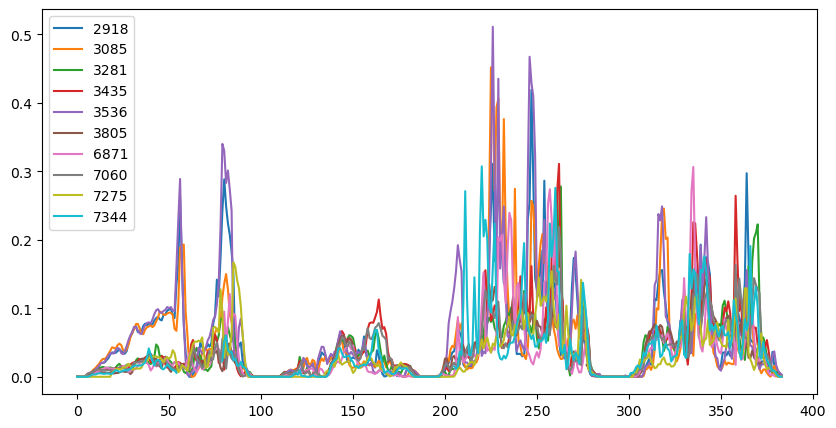

In [58]:
# week of data for 5 systems
pv_ldn_test = pv_ldn.iloc[:int(N_DAYS * DAILY_DATA_POINTS) , :N_SYSTEMS]

# plot week of data for 5 systems
pv_ldn_test.plot(figsize=(10, 5))

<Axes: >

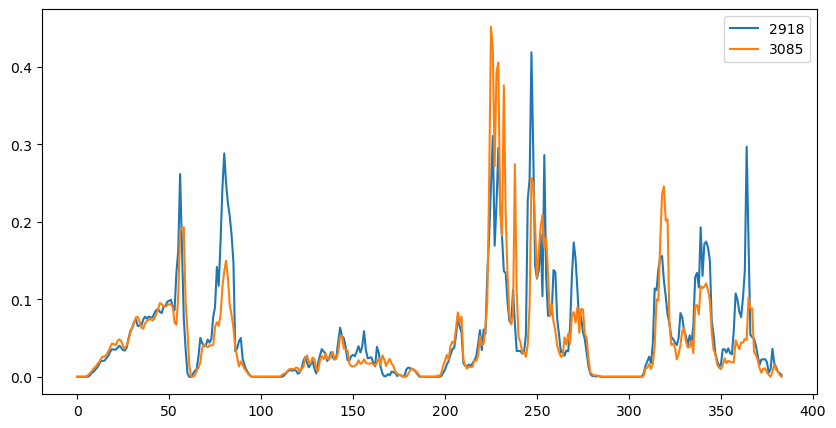

In [59]:
# week of data for 2 systems
pv_ldn_test.iloc[:,:2].plot(figsize=(10, 5))

In [61]:
lats, longs = dl.get_location_maps(df_location=ldn_systems, 
                                   n_systems=N_SYSTEMS)
pv_ldn_test['datetime'] = datetime[:int(N_DAYS * DAILY_DATA_POINTS)]

In [62]:
pv_ldn_stack = dl.stack_dataframe(df_pv=pv_ldn_test,
                                  lats_map=lats,
                                  longs_map=longs)

In [63]:
dl.save_csv(pv_ldn_stack, 'pv_data', 'pv_data_stack.csv')

In [66]:
X = pv_ldn_stack[['epoch', 'latitude', 'longitude']].values
y = pv_ldn_stack['PV'].values

In [67]:
time, r_grid, y = dl.create_spatiotemporal_grid(X, y)

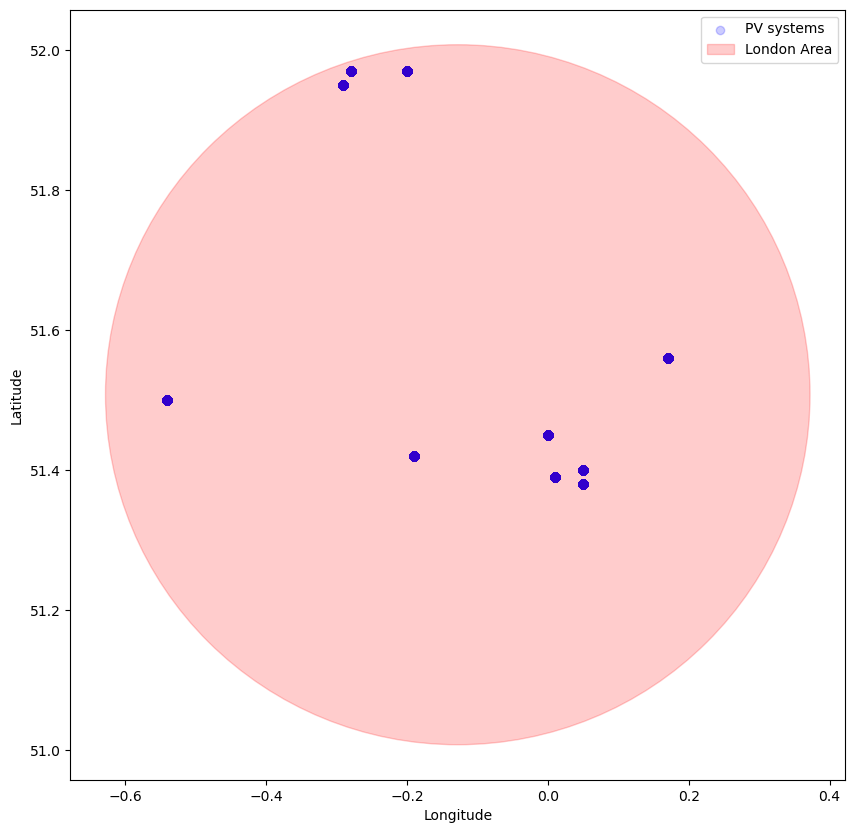

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 2], X[:, 1], alpha=0.2, color='b', label='PV systems')
ldn_circle = plt.Circle((LDN_COORDS[1], LDN_COORDS[0]), RADIUS, color='r', fill=True, alpha=0.2, label='London Area')
ax.add_patch(ldn_circle)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

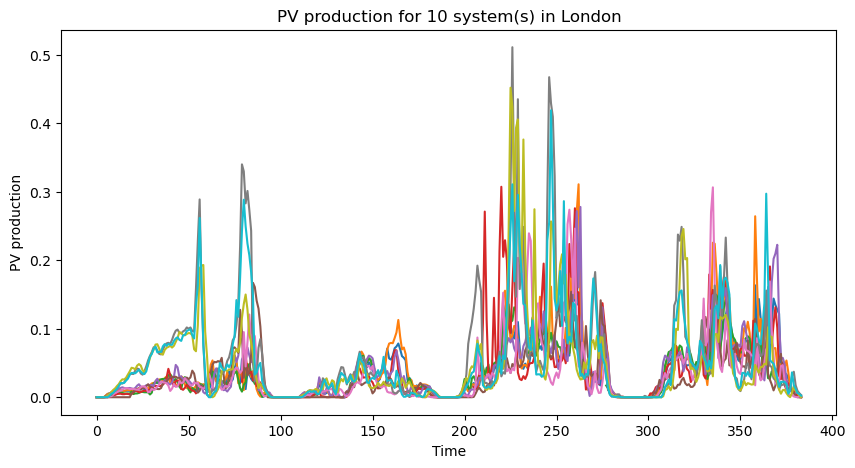

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, y[:,:,0])

ax.set_xlabel('Time')
ax.set_ylabel('PV production')
ax.set_title(f'PV production for {y.shape[1]} system(s) in London');